# Phase 0: Preprocessing the Datasets (DB1 and DB2)

## Convert DB2 MAT files to a single CSV:

In [7]:
# DB2 had to be installed as MATLAB files for each participant, so we don't need to drop any data here, we just need to convert it to a single .csv file.
import os
from scipy.io import loadmat
import pandas as pd
from tqdm import tqdm

inputpath = './data/og/db2-matlab-files'
df = pd.DataFrame()
listdir = os.listdir(inputpath)
count = 0
for file in listdir:
    if file.endswith('mat'):
        # Access the mat file
        file_path = os.path.join(inputpath, file)
        dataset = loadmat(file_path)
        count = count + 1

        # Extract the data into dataframes
        emg_df = pd.DataFrame(dataset['emg'])
        emg_df.rename(columns={
            0: 'emg_0', 1: 'emg_1', 2: 'emg_2',
            3: 'emg_3', 4: 'emg_4', 5: 'emg_5',
            6: 'emg_6', 7: 'emg_7', 8: 'emg_8',
            9: 'emg_9', 10: 'emg_10', 11: 'emg_11'
        }, inplace=True)

        exercise_df = pd.DataFrame(dataset['exercise'])
        exercise_df.rename(columns={0: 'exercise'}, inplace=True)

        subject_df = pd.DataFrame(dataset['subject'])
        subject_df.rename(columns={0: 'subject'}, inplace=True)

        restimulus_df = pd.DataFrame(dataset['restimulus'])
        restimulus_df.rename(columns={0: 'restimulus'}, inplace=True)

        # combine the columns
        current = pd.concat([emg_df, subject_df, exercise_df, restimulus_df], axis="columns")

        # Set the whole exercise column to the exercise
        exercise = current['exercise'].iloc[0]
        current['exercise'] = exercise

        # Set the whole subject column to the subject (as int)
        subject = current['subject'].iloc[0]
        current['subject'] = subject

        # Drop any rows with missing values
        current = current.dropna()

        # Set categorical columns to int
        current['restimulus'] = current['restimulus'].astype(int)
        current['subject'] = current['subject'].astype(int)
        current['exercise'] = current['exercise'].astype(int)

        # Log unique values for subject, restimulus, and exercise
        print(f"\nCURRENT: {count}")
        print(f"Subjects: {current['subject'].unique()}")
        print(f"Exercises: {current['exercise'].unique()}")
        print(f"Restimulus: {current['restimulus'].unique()}")


        # append current df to the main df
        df = pd.concat([df, current], axis="rows")

print(f"\n\nCombined {count} files")
print(f"Unique Subjects: {df['subject'].unique()}")
print(f"Unique Exercises: {df['exercise'].unique()}")
print(f"Unique Restimulus: {df['restimulus'].unique()}")
# save the dataframe to a csv file
df.to_csv(f'./data/db2/db2-full5.csv', index=False)
print("\nFILE SAVED")


CURRENT: 1
Subjects: [1]
Exercises: [1]
Restimulus: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]

CURRENT: 2
Subjects: [1]
Exercises: [2]
Restimulus: [ 0 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40]

CURRENT: 3
Subjects: [1]
Exercises: [3]
Restimulus: [ 0 41 42 43 44 45 46 47 48 49]

CURRENT: 4
Subjects: [2]
Exercises: [1]
Restimulus: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]

CURRENT: 5
Subjects: [2]
Exercises: [2]
Restimulus: [ 0 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40]

CURRENT: 6
Subjects: [2]
Exercises: [3]
Restimulus: [ 0 41 42 43 44 45 46 47 48 49]

CURRENT: 7
Subjects: [3]
Exercises: [1]
Restimulus: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]

CURRENT: 8
Subjects: [3]
Exercises: [2]
Restimulus: [ 0 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40]

CURRENT: 9
Subjects: [3]
Exercises: [3]
Restimulus: [ 0 41 42 43 44 45 46 47 48 49]

CURRENT: 10
Subjects: [4]
Exercises:

## Limit DB1 to first 5 participants:

In [2]:
# DB1 is installed as a huge single .csv file, so we need to limit it to the first 5 participants.
import pandas as pd

# load the csv file
inputpath = './data/og/Ninapro_DB1.csv'
df = pd.read_csv(inputpath)

# Remove all columns except emg, subject, restimulus, and exercise
df = df[['emg_0', 'emg_1', 'emg_2', 'emg_3', 'emg_4', 'emg_5', 'emg_6', 'emg_7', 'emg_8', 'emg_9', 'subject', 'restimulus', 'exercise']]

# drop any rows with missing values
df = df.dropna()

# Set categorical columns to int
df['restimulus'] = df['restimulus'].astype(int)
df['subject'] = df['subject'].astype(int)
df['exercise'] = df['exercise'].astype(int)

# limit the dataframe to the first 5 participants
df = df[df['subject'].isin([1, 2, 3, 4, 5])]

# save the dataframe to a csv file
print(f"Unique Subjects: {df['subject'].unique()}")
print(f"Unique Exercises: {df['exercise'].unique()}")
print(f"Unique Restimulus: {df['restimulus'].unique()}")
df.to_csv(f'./data/db1/db1-full5.csv', index=False)
print("\nFILE SAVED")

Unique Subjects: [1 2 3 4 5]
Unique Exercises: [1 2 3]
Unique Restimulus: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]

FILE SAVED


## Isolate Exercise B and Exercise C for both DB1 and DB2

In [3]:
import pandas as pd
# For DB1, the recorded Exercises are A, B, and C
#db1_exercises = {1: 'A', 2: 'B', 3: 'C'}

# load the csv file for DB1
inputpath = './data/db1/db1-full5.csv'
df = pd.read_csv(inputpath)
print("FINISHED LOADING DB1")

# Save just exercise B and C for DB1
exB_df = df[df['exercise'] == 2]
print(f"Unique Subjects: {exB_df['subject'].unique()}")
print(f"Unique Exercises: {exB_df['exercise'].unique()}")
print(f"Unique Restimulus: {exB_df['restimulus'].unique()}")
exB_df.to_csv('./data/db1/db1-exB.csv', index=False)

print("FINISHED SAVING DB1 - exB")

exC_df = df[df['exercise'] == 3]
print(f"Unique Subjects: {exC_df['subject'].unique()}")
print(f"Unique Exercises: {exC_df['exercise'].unique()}")
print(f"Unique Restimulus: {exC_df['restimulus'].unique()}")
exC_df.to_csv('./data/db1/db1-exC.csv', index=False)

print("FINISHED SAVING DB1 - exC")

print("FINISHED SAVING DB1")

# For DB2, the recorded Exercises are B, C, and D
#db2_exercises = {1: 'B', 2: 'C', 3: 'D'}

# load the csv file for DB2
inputpath = './data/db2/db2-full5.csv'
df = pd.read_csv(inputpath)
print("FINISHED LOADING DB2")

# Save just exercise B and C for DB2
exB_df = df[df['exercise'] == 1]
print(f"Unique Subjects: {exB_df['subject'].unique()}")
print(f"Unique Exercises: {exB_df['exercise'].unique()}")
print(f"Unique Restimulus: {exB_df['restimulus'].unique()}")
exB_df.to_csv('./data/db2/db2-exB.csv', index=False)

print("FINISHED SAVING DB2 - exB")

exC_df = df[df['exercise'] == 2]
print(f"Unique Subjects: {exC_df['subject'].unique()}")
print(f"Unique Exercises: {exC_df['exercise'].unique()}")
print(f"Unique Restimulus: {exC_df['restimulus'].unique()}")
exC_df.to_csv('./data/db2/db2-exC.csv', index=False)

print("FINISHED SAVING DB2 - exC")

print("ALL DONE!")

FINISHED LOADING DB1
Unique Subjects: [1 2 3 4 5]
Unique Exercises: [2]
Unique Restimulus: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
FINISHED SAVING DB1 - exB
Unique Subjects: [1 2 3 4 5]
Unique Exercises: [3]
Unique Restimulus: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
FINISHED SAVING DB1 - exC
FINISHED SAVING DB1
FINISHED LOADING DB2
Unique Subjects: [1 2 3 4 5]
Unique Exercises: [1]
Unique Restimulus: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
FINISHED SAVING DB2 - exB
Unique Subjects: [1 2 3 4 5]
Unique Exercises: [2]
Unique Restimulus: [ 0 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40]
FINISHED SAVING DB2 - exC
ALL DONE!


## Create label column from the restimulus column + exercise

In [3]:
import pandas as pd

# DB1 Labels (Exercise 2 and 3)
gesture_labels_db1 = [
    {"exercise": 2, "restimulus": 0, "gesture": 0, "label": "rest"},
    {"exercise": 2, "restimulus": 1, "gesture": 13, "label": "thumb up"},
    {"exercise": 2, "restimulus": 2, "gesture": 14, "label": "extension of index and moddle, flexion of the others"},
    {"exercise": 2, "restimulus": 3, "gesture": 15, "label": "flexion of ring and little finger, extension of the others"},
    {"exercise": 2, "restimulus": 4, "gesture": 16, "label": "thumb opposing base of little finger"},
    {"exercise": 2, "restimulus": 5, "gesture": 17, "label": "abduction of all fingers"},
    {"exercise": 2, "restimulus": 6, "gesture": 18, "label": "fingers flexed together in fist"},
    {"exercise": 2, "restimulus": 7, "gesture": 19, "label": "pointing index"},
    {"exercise": 2, "restimulus": 8, "gesture": 20, "label": "adduction of extended fingers"},
    {"exercise": 2, "restimulus": 9, "gesture": 21, "label": "wrist supination (axis: middle finger)"},
    {"exercise": 2, "restimulus": 10, "gesture": 22, "label": "wrist pronation (axis: middle finger)"},
    {"exercise": 2, "restimulus": 11, "gesture": 23, "label": "wrist supination (axis: little finger)"},
    {"exercise": 2, "restimulus": 12, "gesture": 24, "label": "wrist pronation (axis: little finger)"},
    {"exercise": 2, "restimulus": 13, "gesture": 25, "label": "wrist flexion"},
    {"exercise": 2, "restimulus": 14, "gesture": 26, "label": "wrist extension"},
    {"exercise": 2, "restimulus": 15, "gesture": 27, "label": "wrist radial deviation"},
    {"exercise": 2, "restimulus": 16, "gesture": 28, "label": "wrist ulnar deviation"},
    {"exercise": 2, "restimulus": 17, "gesture": 29, "label": "wrist extension with closed hand"},
    {"exercise": 3, "restimulus": 0, "gesture": 0, "label": "rest"},
    {"exercise": 3, "restimulus": 1, "gesture": 30, "label": "large diameter grasp"},
    {"exercise": 3, "restimulus": 2, "gesture": 31, "label": "small diameter grasp (power grip)"},
    {"exercise": 3, "restimulus": 3, "gesture": 32, "label": "fixed hook grasp"},
    {"exercise": 3, "restimulus": 4, "gesture": 33, "label": "index finger extension grasp"},
    {"exercise": 3, "restimulus": 5, "gesture": 34, "label": "medium wrap"},
    {"exercise": 3, "restimulus": 6, "gesture": 35, "label": "ring grasp"},
    {"exercise": 3, "restimulus": 7, "gesture": 36, "label": "prismatic four fingers grasp"},
    {"exercise": 3, "restimulus": 8, "gesture": 37, "label": "stick grasp"},
    {"exercise": 3, "restimulus": 9, "gesture": 38, "label": "writing tripod grasp"},
    {"exercise": 3, "restimulus": 10, "gesture": 39, "label": "power sphere grasp"},
    {"exercise": 3, "restimulus": 11, "gesture": 40, "label": "three finger sphere grasp"},
    {"exercise": 3, "restimulus": 12, "gesture": 41, "label": "precision sphere grasp"},
    {"exercise": 3, "restimulus": 13, "gesture": 42, "label": "tripod grasp"},
    {"exercise": 3, "restimulus": 14, "gesture": 43, "label": "prismatic pinch grasp"},
    {"exercise": 3, "restimulus": 15, "gesture": 44, "label": "tip pinch grasp"},
    {"exercise": 3, "restimulus": 16, "gesture": 45, "label": "quadpod grasp"},
    {"exercise": 3, "restimulus": 17, "gesture": 46, "label": "lateral grasp"},
    {"exercise": 3, "restimulus": 18, "gesture": 47, "label": "parallel extension grasp"},
    {"exercise": 3, "restimulus": 19, "gesture": 48, "label": "extension type grasp"},
    {"exercise": 3, "restimulus": 20, "gesture": 49, "label": "power disk grasp"},
    {"exercise": 3, "restimulus": 21, "gesture": 50, "label": "open a bottle with a tripod grasp"},
    {"exercise": 3, "restimulus": 22, "gesture": 51, "label": "turn a screw (grasp the screwdriver with a stick grasp)"},
    {"exercise": 3, "restimulus": 23, "gesture": 52, "label": "cut something (grasp the knife with an index finger extension grasp)"}
]

# Convert gesture_labels_db1 to a DataFrame and save as a CSV
gesture_labels_db1_df = pd.DataFrame(gesture_labels_db1)
gesture_labels_db1_df.to_csv("./data/db1/db1_gesture_labels.csv", index=False)

# DB2 Labels (Exercise 1 and 2)
gesture_labels_db2 = [
    {"exercise": 1, "restimulus": 0, "gesture": 0, "label": "rest"},
    {"exercise": 1, "restimulus": 1, "gesture": 13, "label": "thumb up"},
    {"exercise": 1, "restimulus": 2, "gesture": 14, "label": "extension of index and moddle, flexion of the others"},
    {"exercise": 1, "restimulus": 3, "gesture": 15, "label": "flexion of ring and little finger, extension of the others"},
    {"exercise": 1, "restimulus": 4, "gesture": 16, "label": "thumb opposing base of little finger"},
    {"exercise": 1, "restimulus": 5, "gesture": 17, "label": "abduction of all fingers"},
    {"exercise": 1, "restimulus": 6, "gesture": 18, "label": "fingers flexed together in fist"},
    {"exercise": 1, "restimulus": 7, "gesture": 19, "label": "pointing index"},
    {"exercise": 1, "restimulus": 8, "gesture": 20, "label": "adduction of extended fingers"},
    {"exercise": 1, "restimulus": 9, "gesture": 21, "label": "wrist supination (axis: middle finger)"},
    {"exercise": 1, "restimulus": 10, "gesture": 22, "label": "wrist pronation (axis: middle finger)"},
    {"exercise": 1, "restimulus": 11, "gesture": 23, "label": "wrist supination (axis: little finger)"},
    {"exercise": 1, "restimulus": 12, "gesture": 24, "label": "wrist pronation (axis: little finger)"},
    {"exercise": 1, "restimulus": 13, "gesture": 25, "label": "wrist flexion"},
    {"exercise": 1, "restimulus": 14, "gesture": 26, "label": "wrist extension"},
    {"exercise": 1, "restimulus": 15, "gesture": 27, "label": "wrist radial deviation"},
    {"exercise": 1, "restimulus": 16, "gesture": 28, "label": "wrist ulnar deviation"},
    {"exercise": 1, "restimulus": 17, "gesture": 29, "label": "wrist extension with closed hand"},
    {"exercise": 2, "restimulus": 0, "gesture": 0, "label": "rest"},
    {"exercise": 2, "restimulus": 18, "gesture": 30, "label": "large diameter grasp"},
    {"exercise": 2, "restimulus": 19, "gesture": 31, "label": "small diameter grasp (power grip)"},
    {"exercise": 2, "restimulus": 20, "gesture": 32, "label": "fixed hook grasp"},
    {"exercise": 2, "restimulus": 21, "gesture": 33, "label": "index finger extension grasp"},
    {"exercise": 2, "restimulus": 22, "gesture": 34, "label": "medium wrap"},
    {"exercise": 2, "restimulus": 23, "gesture": 35, "label": "ring grasp"},
    {"exercise": 2, "restimulus": 24, "gesture": 36, "label": "prismatic four fingers grasp"},
    {"exercise": 2, "restimulus": 25, "gesture": 37, "label": "stick grasp"},
    {"exercise": 2, "restimulus": 26, "gesture": 38, "label": "writing tripod grasp"},
    {"exercise": 2, "restimulus": 27, "gesture": 39, "label": "power sphere grasp"},
    {"exercise": 2, "restimulus": 28, "gesture": 40, "label": "three finger sphere grasp"},
    {"exercise": 2, "restimulus": 29, "gesture": 41, "label": "precision sphere grasp"},
    {"exercise": 2, "restimulus": 30, "gesture": 42, "label": "tripod grasp"},
    {"exercise": 2, "restimulus": 31, "gesture": 43, "label": "prismatic pinch grasp"},
    {"exercise": 2, "restimulus": 32, "gesture": 44, "label": "tip pinch grasp"},
    {"exercise": 2, "restimulus": 33, "gesture": 45, "label": "quadpod grasp"},
    {"exercise": 2, "restimulus": 34, "gesture": 46, "label": "lateral grasp"},
    {"exercise": 2, "restimulus": 35, "gesture": 47, "label": "parallel extension grasp"},
    {"exercise": 2, "restimulus": 36, "gesture": 48, "label": "extension type grasp"},
    {"exercise": 2, "restimulus": 37, "gesture": 49, "label": "power disk grasp"},
    {"exercise": 2, "restimulus": 38, "gesture": 50, "label": "open a bottle with a tripod grasp"},
    {"exercise": 2, "restimulus": 39, "gesture": 51, "label": "turn a screw (grasp the screwdriver with a stick grasp)"},
    {"exercise": 2, "restimulus": 40, "gesture": 52, "label": "cut something (grasp the knife with an index finger extension grasp)"}
]

# Convert gesture_labels_db2 to a DataFrame and save as a CSV
gesture_labels_db2_df = pd.DataFrame(gesture_labels_db2)
gesture_labels_db2_df.to_csv("./data/db2/db2_gesture_labels.csv", index=False)

In [5]:
import pandas as pd
from tqdm import tqdm

# Load the gesture_labels_db1 and gesture_labels_db2 CSV files
gesture_labels_db1_df = pd.read_csv("./data/db1/db1_gesture_labels.csv")
gesture_labels_db2_df = pd.read_csv("./data/db2/db2_gesture_labels.csv")

# List of CSV files to process
files_to_label = ["db1-exB.csv", "db1-exC.csv", "db2-exB.csv", "db2-exC.csv"]

# Iterate over the CSV files, perform the merge, and save the resulting DataFrame
for file in tqdm(files_to_label):
    if "db1" in file:
        gesture_labels = gesture_labels_db1_df
        path = "./data/db1/"
    else:
        gesture_labels = gesture_labels_db2_df
        path = "./data/db2/"

    df = pd.read_csv(path + file)

    # Perform merge to create gesture and label columns
    df = pd.merge(df, gesture_labels, how="left", on=["exercise", "restimulus"])

    # Drop any rows with missing values
    df = df.dropna()

    # Drop the exercise and restimulus columns
    df = df.drop(["exercise", "restimulus"], axis=1)

    # Save the resulting DataFrame to a CSV file
    print(f"\nFile: {file}")
    print(f"Unique Subjects: {df['subject'].unique()}")
    print(f"Unique Exercises: {df['gesture'].unique()}")
    print(f"Unique Restimulus: {df['label'].unique()}")
    df.to_csv(path + file.rstrip(".csv") + "-gestures.csv", index=False)

print("\nALL DONE!")

  0%|          | 0/4 [00:00<?, ?it/s]


File: db1-exB.csv
Unique Subjects: [1 2 3 4 5]
Unique Exercises: [ 0 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29]
Unique Restimulus: ['rest' 'thumb up' 'extension of index and moddle, flexion of the others'
 'flexion of ring and little finger, extension of the others'
 'thumb opposing base of little finger' 'abduction of all fingers'
 'fingers flexed together in fist' 'pointing index'
 'adduction of extended fingers' 'wrist supination (axis: middle finger)'
 'wrist pronation (axis: middle finger)'
 'wrist supination (axis: little finger)'
 'wrist pronation (axis: little finger)' 'wrist flexion' 'wrist extension'
 'wrist radial deviation' 'wrist ulnar deviation'
 'wrist extension with closed hand']


 25%|██▌       | 1/4 [00:05<00:16,  5.42s/it]


File: db1-exC.csv
Unique Subjects: [1 2 3 4 5]
Unique Exercises: [ 0 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52]
Unique Restimulus: ['rest' 'large diameter grasp' 'small diameter grasp (power grip)'
 'fixed hook grasp' 'index finger extension grasp' 'medium wrap'
 'ring grasp' 'prismatic four fingers grasp' 'stick grasp'
 'writing tripod grasp' 'power sphere grasp' 'three finger sphere grasp'
 'precision sphere grasp' 'tripod grasp' 'prismatic pinch grasp'
 'tip pinch grasp' 'quadpod grasp' 'lateral grasp'
 'parallel extension grasp' 'extension type grasp' 'power disk grasp'
 'open a bottle with a tripod grasp'
 'turn a screw (grasp the screwdriver with a stick grasp)'
 'cut something (grasp the knife with an index finger extension grasp)']


 50%|█████     | 2/4 [00:14<00:14,  7.34s/it]


File: db2-exB.csv
Unique Subjects: [1 2 3 4 5]
Unique Exercises: [ 0 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29]
Unique Restimulus: ['rest' 'thumb up' 'extension of index and moddle, flexion of the others'
 'flexion of ring and little finger, extension of the others'
 'thumb opposing base of little finger' 'abduction of all fingers'
 'fingers flexed together in fist' 'pointing index'
 'adduction of extended fingers' 'wrist supination (axis: middle finger)'
 'wrist pronation (axis: middle finger)'
 'wrist supination (axis: little finger)'
 'wrist pronation (axis: little finger)' 'wrist flexion' 'wrist extension'
 'wrist radial deviation' 'wrist ulnar deviation'
 'wrist extension with closed hand']


 75%|███████▌  | 3/4 [02:11<00:57, 57.63s/it]


File: db2-exC.csv
Unique Subjects: [1 2 3 4 5]
Unique Exercises: [ 0 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52]
Unique Restimulus: ['rest' 'large diameter grasp' 'small diameter grasp (power grip)'
 'fixed hook grasp' 'index finger extension grasp' 'medium wrap'
 'ring grasp' 'prismatic four fingers grasp' 'stick grasp'
 'writing tripod grasp' 'power sphere grasp' 'three finger sphere grasp'
 'precision sphere grasp' 'tripod grasp' 'prismatic pinch grasp'
 'tip pinch grasp' 'quadpod grasp' 'lateral grasp'
 'parallel extension grasp' 'extension type grasp' 'power disk grasp'
 'open a bottle with a tripod grasp'
 'turn a screw (grasp the screwdriver with a stick grasp)'
 'cut something (grasp the knife with an index finger extension grasp)']


100%|██████████| 4/4 [05:01<00:00, 75.36s/it] 


ALL DONE!


## Apply PCA to visualize data separability

C:\Users\MaxHu\anaconda3\envs\py-3.12\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


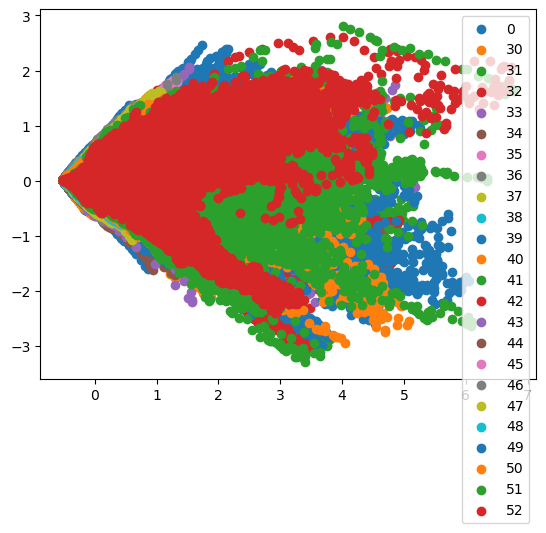

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# load the csv file
inputpath = './data/db1/db1-exC-gestures.csv'
df = pd.read_csv(inputpath)

# extract the gesture and label columns
gestures = df['gesture'].values
labels = df['label'].values

# perform LDA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(df[['emg_0', 'emg_1', 'emg_2', 'emg_3', 'emg_4', 'emg_5', 'emg_6', 'emg_7', 'emg_8', 'emg_9']].values)

# plot the data (different color for each gesture)
fig, ax = plt.subplots()
for gesture in np.unique(gestures):
    ax.scatter(X_pca[gestures == gesture, 0], X_pca[gestures == gesture, 1], label=gesture)
ax.legend()
plt.show()

## Plot Average EMG and Gesture over time

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# load the csv file
inputpath = './data/db1/db1-exB-gestures.csv'
df = pd.read_csv(inputpath)

MAX_SAMPLES = 9999999999

# extract the gesture and avg emg
emg_channels = [col for col in df.columns if "emg" in col]
df['mean_emg'] = df[emg_channels].mean(axis=1)

# plot the data (different color for each gesture)
fig, ax1 = plt.subplots(figsize=(15, 4))

# Plot average EMG signal
ax1.plot(df['mean_emg'].head(MAX_SAMPLES), color='black', linewidth=1, label='Mean EMG')
ax1.set_ylabel('Mean EMG')
ax1.set_xlabel('Time (samples)')
ax1.grid(True)

# Plot restimulus (gesture labels) on second axis
ax2 = ax1.twinx()
ax2.plot(df['gesture'].head(MAX_SAMPLES), color='red', alpha=0.5, label='Gesture')
ax2.set_ylabel('Gesture Label')

plt.title('DB1 Exercise B')
fig.tight_layout()
plt.show()

## Adjust Sampling Rate of DB2 from 2000Hz to 200Hz

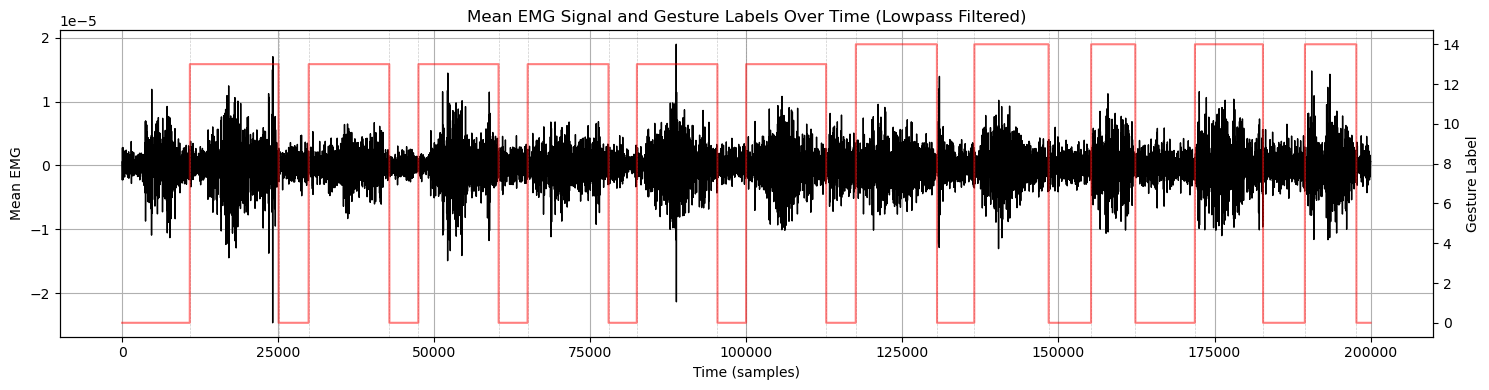

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from scipy.signal import decimate

def lowpass_filter(data, cutoff=40.0, fs=2000.0, order=4):
    nyq = 0.5 * fs  # Nyquist frequency
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low')
    return filtfilt(b, a, data, axis=0)

# load the csv file
inputpath = './data/db2/db2-exB-gestures.csv'
df = pd.read_csv(inputpath)

MAX_SAMPLES = 200000
FILTER = True
df = df.head(MAX_SAMPLES)

# extract the gesture and avg emg
emg_channels = [col for col in df.columns if "emg" in col]
# Apply bandpass filter
if FILTER:
    emg_values = lowpass_filter(df[emg_channels].values)
else:
    emg_values = df[emg_channels].values

avg_emg = np.mean(emg_values, axis=1)

# plot the data (different color for each gesture)
fig, ax1 = plt.subplots(figsize=(15, 4))

# Plot average EMG signal
ax1.plot(avg_emg, color='black', linewidth=1, label='Mean EMG')
ax1.set_ylabel('Mean EMG')
ax1.set_xlabel('Time (samples)')
ax1.grid(True)

# Plot restimulus (gesture labels) on second axis
ax2 = ax1.twinx()
ax2.plot(df['gesture'], color='red', alpha=0.5, label='Gesture')
ax2.set_ylabel('Gesture Label')

# Optional: Overlay vertical lines on gesture changes
gesture_changes = df['gesture'].diff().fillna(0) != 0
for idx in df[gesture_changes].index:
    ax1.axvline(x=idx, color='gray', linestyle='--', linewidth=0.5, alpha=0.4)

plt.title('Mean EMG Signal and Gesture Labels Over Time (Lowpass Filtered)')
fig.tight_layout()
plt.show()

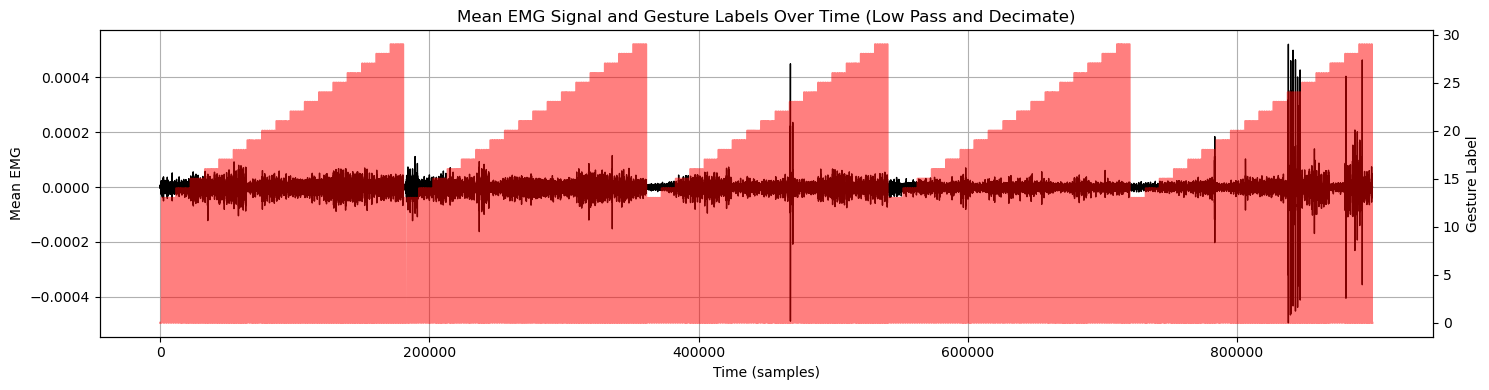

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import decimate

# load the csv file
inputpath = './data/db2/db2-exB-gestures.csv'
df = pd.read_csv(inputpath)

MAX_SAMPLES = 9999999999
FILTER = True

# extract the gesture and avg emg
emg_channels = [col for col in df.columns if "emg" in col]
# Apply bandpass filter
if FILTER:
    emg_values = decimate(df[emg_channels].values, q=10, axis=0)

    # Resample labels
    gesture_downsampled = df['gesture'].iloc[::10].reset_index(drop=True).values
else:
    emg_values = df[emg_channels].values

avg_emg = np.mean(emg_values, axis=1)

df = pd.DataFrame([avg_emg, gesture_downsampled], index=['avg_emg', 'gesture_downsampled']).T

df = df.head(MAX_SAMPLES)

# plot the data (different color for each gesture)
fig, ax1 = plt.subplots(figsize=(15, 4))

# Plot average EMG signal
ax1.plot(df['avg_emg'], color='black', linewidth=1, label='Mean EMG')
ax1.set_ylabel('Mean EMG')
ax1.set_xlabel('Time (samples)')
ax1.grid(True)

# Plot restimulus (gesture labels) on second axis
ax2 = ax1.twinx()
ax2.plot(df['gesture_downsampled'], color='red', alpha=0.5, label='Gesture')
ax2.set_ylabel('Gesture Label')

plt.title('Mean EMG Signal and Gesture Labels Over Time (Low Pass and Decimate)')
fig.tight_layout()
plt.show()

In [18]:
files_to_downsample = ["db2-exB-gestures.csv", "db2-exC-gestures.csv"]

for file in files_to_downsample:
    df = pd.read_csv(f"./data/db2/{file}")

    # Use decimate to downsample the data
    emg_channels = [col for col in df.columns if "emg" in col]
    emg_values = decimate(df[emg_channels].values, q=10, axis=0)
    gesture_downsampled = df['gesture'].iloc[::10].reset_index(drop=True).values

    new_df = pd.DataFrame(emg_values, columns=emg_channels)
    new_df['gesture'] = gesture_downsampled

    new_df.to_csv(f"./data/db2/{file.rstrip('.csv')}-ds.csv", index=False)
